In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import swifter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import torch.nn.functional as F
import torch
from torch.nn.functional import softmax

tqdm.pandas()

def remove_math_expressions(text):
    # Remove LaTeX math expressions: $...$, $$...$$, \(...\), \[...\]
    text = re.sub(r'\$\$.*?\$\$', '', text, flags=re.DOTALL)
    text = re.sub(r'\$.*?\$', '', text, flags=re.DOTALL)
    text = re.sub(r'\\\[(.*?)\\\]', '', text, flags=re.DOTALL)
    text = re.sub(r'\\\((.*?)\\\)', '', text, flags=re.DOTALL)
    # Remove LaTeX environment blocks
    text = re.sub(r'\\begin\{.*?\}.*?\\end\{.*?\}', '', text, flags=re.DOTALL)
    # Remove HTML <math> tags
    text = re.sub(r'<math.*?>.*?</math>', '', text, flags=re.DOTALL)
    return text

C:\Users\jiali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_folder = r"C:\Users\jiali\OneDrive - TUM\Studium\Data-Mining\physics.stackexchange.com\CSV"
csv_path = os.path.join(csv_folder, "Posts.csv")
df = pd.read_csv(csv_path)

In [3]:
df['AcceptedAnswerId'] = df['AcceptedAnswerId'].fillna(0)
df['ViewCount'] = df['ViewCount'].fillna(0)
df['AnswerCount'] = df['AnswerCount'].fillna(0)
df.dropna(subset=['Body'], inplace=True)
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
df['LastEditDate'] = pd.to_datetime(df['LastEditDate'])
df['LastActivityDate'] = pd.to_datetime(df['LastActivityDate'])

In [4]:
df.columns

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'LastEditorUserId', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'ContentLicense', 'ParentId', 'OwnerDisplayName', 'ClosedDate',
       'LastEditorDisplayName', 'CommunityOwnedDate', 'FavoriteCount'],
      dtype='object')

In [ ]:
# Remove math expressions from the body text before sentiment analysis
df['CleanBodyNoMath'] = df['Body'].apply(remove_math_expressions)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to extract the compound score from VADER output
def get_compound_score(text):
    return analyzer.polarity_scores(text)['compound']

# Apply sentiment scoring to the cleaned text with a progress bar
df['SentimentScore'] = df['CleanBodyNoMath'].progress_apply(get_compound_score)

# Function to classify sentiment based on compound score thresholds
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment classification
df['SentimentLabel_Vader'] = df['SentimentScore'].apply(classify_sentiment)


100%|██████████| 576958/576958 [11:05<00:00, 866.91it/s] 


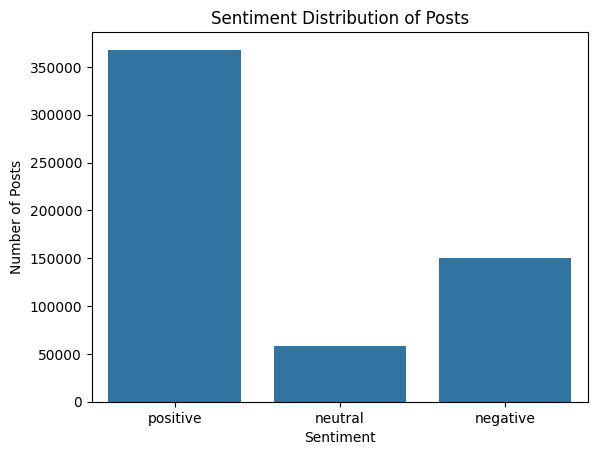

In [ ]:

sns.countplot(data=df, x='SentimentLabel_Vedar', order=['positive', 'neutral', 'negative'])
plt.title("Sentiment Distribution of Posts")
plt.xlabel("Sentiment")
plt.ylabel("Number of Posts")
plt.show()


In [ ]:
# Filter the first 5 posts classified as negative sentiment
negative_posts = df[df['SentimentLabel_Vader'] == 'negative']

# Display only the cleaned body text and sentiment score
negative_posts[['CleanBodyNoMath', 'SentimentScore']].head(5)


,CleanBodyNoMath,SentimentScore
5,What are the main problems that we need to sol...,-0.5106
9,"I've been using the term ""sound"" all my life, ...",-0.3088
11,I know that there's big controversy between tw...,-0.2960
14,"Experiments such as the double-slit, EPR and B...",-0.7096
23,We've learned that the wave function of a part...,-0.7131


In [ ]:
# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move model to GPU if available
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Label mapping for the model's output
label_map = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}

# Batch sentiment inference function
def batched_sentiment(text_list, batch_size=64):
    results = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Sentiment Analysis"):
        batch = text_list[i:i+batch_size]
        encodings = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )
        encodings = {k: v.to(model.device) for k, v in encodings.items()}

        with torch.no_grad():
            output = model(**encodings)
            probs = softmax(output.logits, dim=-1)
            scores, labels = torch.max(probs, dim=1)
            for score, label in zip(scores, labels):
                results.append({
                    "label": label_map[f'LABEL_{label.item()}'],
                    "score": round(score.item(), 4)
                })
    return results

# Ensure input is string
df['CleanBodyNoMath'] = df['CleanBodyNoMath'].astype(str)

# Run sentiment analysis in batches
results = batched_sentiment(df['CleanBodyNoMath'].tolist(), batch_size=64)

# Add results to DataFrame
df['SentimentLabel'] = [r['label'] for r in results]
df['SentimentScore'] = [r['score'] for r in results]

Sentiment Analysis: 100%|██████████| 9015/9015 [1:46:38<00:00,  1.41it/s]


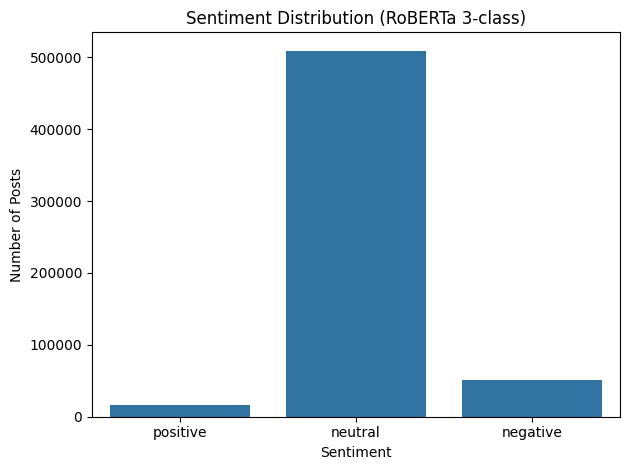

In [13]:
sns.countplot(data=df, x='SentimentLabel', order=['positive', 'neutral', 'negative'])
plt.title("Sentiment Distribution (RoBERTa 3-class)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()


In [ ]:
# Filter posts classified as negative sentiment
negative_posts = df[df['SentimentLabel'] == 'negative']

# Display the cleaned post body and sentiment label/score
negative_posts[['CleanBodyNoMath', 'SentimentLabel', 'SentimentScore']].head(5)

,CleanBodyNoMath,SentimentLabel,SentimentScore
9,"I've been using the term ""sound"" all my life, ...",negative,0.7173
25,"\nA person drove 120 miles at 40 mph, then dro...",negative,0.6468
28,There is a common myth that water flowing out ...,negative,0.5031
44,String theory should come with a proposal for ...,negative,0.6629
50,They are not producing energy; their movement ...,negative,0.5008


In [ ]:
# Save the DataFrame with sentiment results to a CSV file
output_path = "sentiment_results.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"Successfully saved to {output_path}")


已成功保存到 sentiment_results.csv


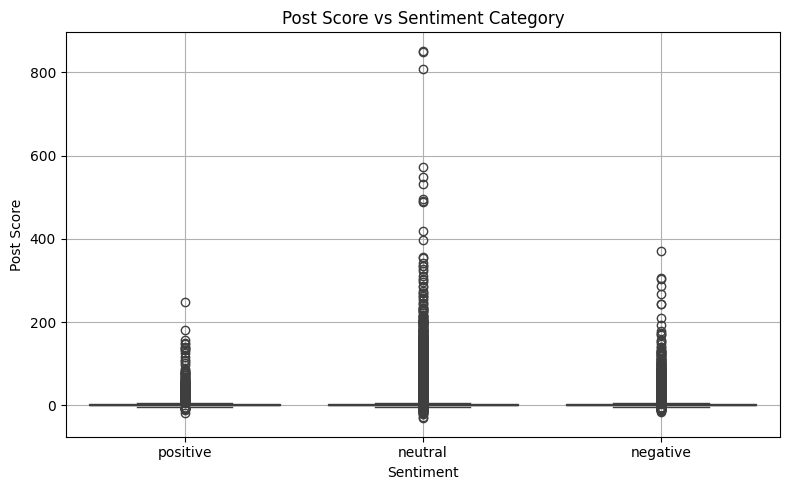

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='SentimentLabel', y='Score', order=['positive', 'neutral', 'negative'])
plt.title("Post Score vs Sentiment Category")
plt.xlabel("Sentiment")
plt.ylabel("Post Score")
plt.grid(True)
plt.tight_layout()
plt.show()


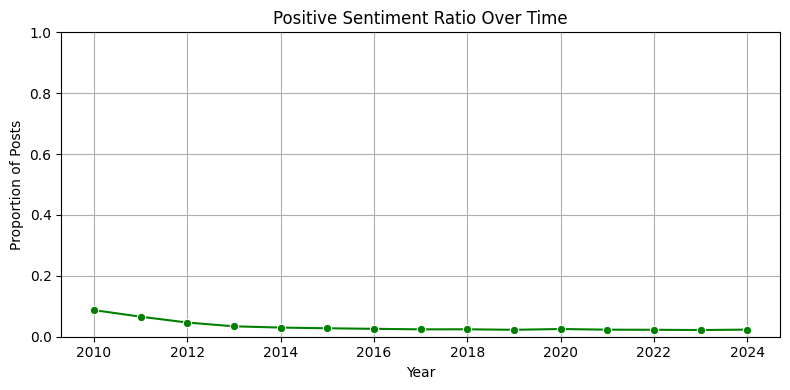

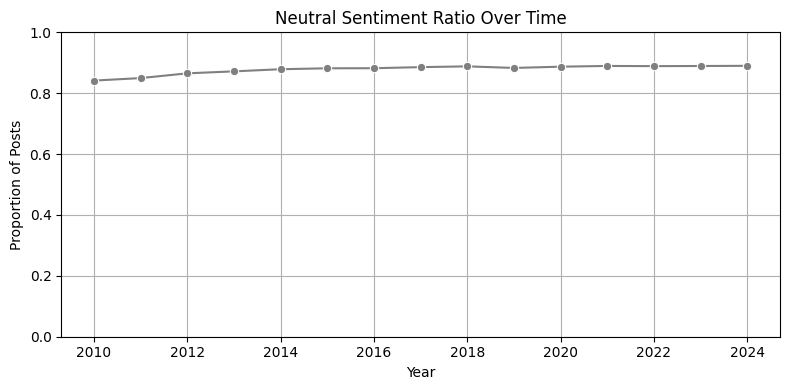

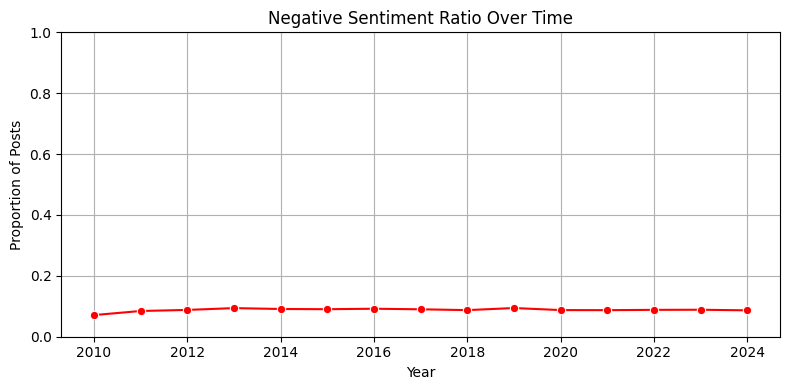

In [ ]:
# Convert creation date to datetime and extract year
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
df['Year'] = df['CreationDate'].dt.year

# Filter out rows without sentiment labels
df_sent = df[df['SentimentLabel'].notnull()]

# Count the number of posts per sentiment per year
yearly_counts = df_sent.groupby(['Year', 'SentimentLabel']).size().reset_index(name='Count')

# Count total posts per year (for percentage calculation)
yearly_totals = df_sent.groupby('Year').size().reset_index(name='Total')

# Merge totals into the sentiment breakdown
df_plot = pd.merge(yearly_counts, yearly_totals, on='Year')
df_plot['Percent'] = df_plot['Count'] / df_plot['Total']

# Set color mapping for each sentiment
color_map = {
    'positive': 'green',
    'neutral': 'gray',
    'negative': 'red'
}

# Plot separate trend lines for each sentiment
sentiments = ['positive', 'neutral', 'negative']

for sentiment in sentiments:
    data = df_plot[df_plot['SentimentLabel'] == sentiment]
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=data, x='Year', y='Percent', marker='o', color=color_map[sentiment])
    plt.title(f"{sentiment.capitalize()} Sentiment Ratio Over Time")
    plt.ylabel("Proportion of Posts")
    plt.xlabel("Year")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


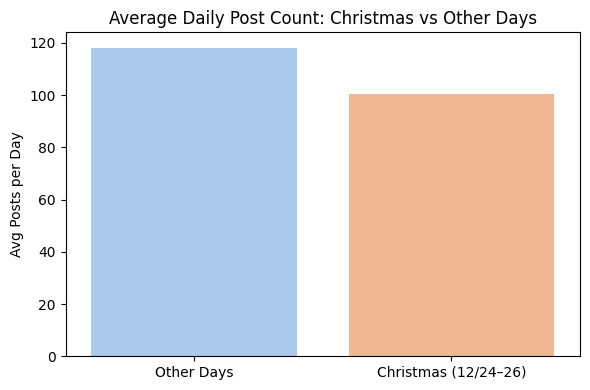

In [ ]:
# Convert CreationDate to datetime format
df['CreationDate'] = pd.to_datetime(df['CreationDate'])

# Extract daily, monthly, and day-of-month values
df['Date'] = df['CreationDate'].dt.date
df['Month'] = df['CreationDate'].dt.month
df['Day'] = df['CreationDate'].dt.day

# Flag Christmas holiday period (Dec 24–31 inclusive)
df['IsChristmas'] = (df['Month'] == 12) & (df['Day'].isin([24, 25, 26, 27, 28, 29, 30, 31]))

# 🎄 Analysis 1: Average daily post count
daily_counts = df.groupby(['Date', 'IsChristmas']).size().reset_index(name='PostCount')
avg_daily = daily_counts.groupby('IsChristmas')['PostCount'].mean().reset_index()

# Map label for clarity
avg_daily['Label'] = avg_daily['IsChristmas'].map({
    True: 'Christmas (12/24–31)',
    False: 'Other Days'
})

# Plot average daily post count: Christmas vs non-Christmas
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_daily, x='Label', y='PostCount', palette='pastel')
plt.title("Average Daily Post Count: Christmas vs Other Days")
plt.ylabel("Avg Posts per Day")
plt.xlabel("")
plt.tight_layout()
plt.show()


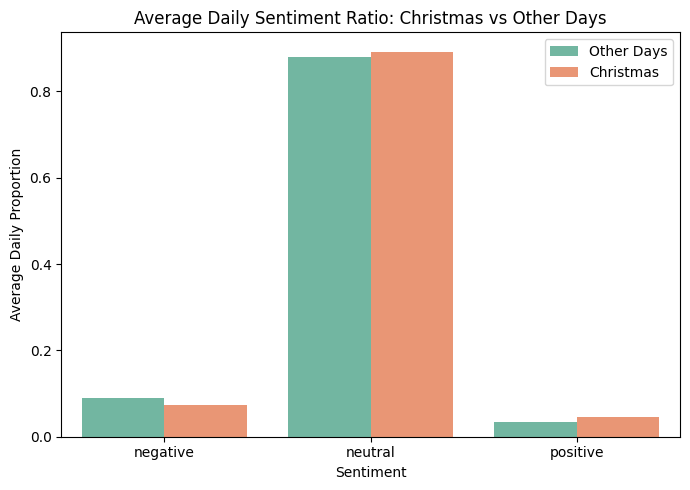

In [ ]:
# Filter only posts with sentiment labels
df_sent = df[df['SentimentLabel'].notnull()].copy()

# Count the number of posts per sentiment per day
daily_sent = df_sent.groupby(['Date', 'SentimentLabel']).size().reset_index(name='Count')

# Compute total posts per day (for percentage calculation)
daily_total = df_sent.groupby('Date').size().reset_index(name='Total')

# Merge to calculate proportion per sentiment per day
daily_merged = pd.merge(daily_sent, daily_total, on='Date')
daily_merged['Percent'] = daily_merged['Count'] / daily_merged['Total']

# Mark Christmas days (Dec 24–26)
daily_merged['IsChristmas'] = (
    pd.to_datetime(daily_merged['Date']).dt.month.eq(12) &
    pd.to_datetime(daily_merged['Date']).dt.day.isin([24, 25, 26])
)

# Calculate average daily proportion of each sentiment (grouped by Christmas vs non-Christmas)
avg_sentiment = (
    daily_merged
    .groupby(['IsChristmas', 'SentimentLabel'])['Percent']
    .mean()
    .reset_index()
)

# Add readable group labels
avg_sentiment['Group'] = avg_sentiment['IsChristmas'].map({True: 'Christmas', False: 'Other Days'})

# Plot the average daily sentiment distribution
plt.figure(figsize=(7, 5))
sns.barplot(data=avg_sentiment, x='SentimentLabel', y='Percent', hue='Group', palette='Set2')
plt.title("Average Daily Sentiment Ratio: Christmas vs Other Days")
plt.ylabel("Average Daily Proportion")
plt.xlabel("Sentiment")
plt.legend(title="")
plt.tight_layout()
plt.show()


CommentCount vs SentimentScore: ρ = -0.065, p = 0.0000


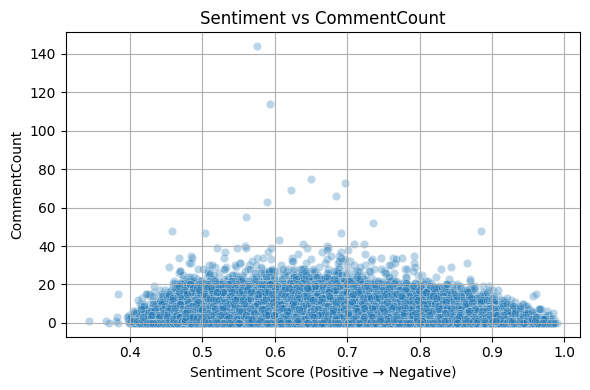

ViewCount vs SentimentScore: ρ = -0.069, p = 0.0000


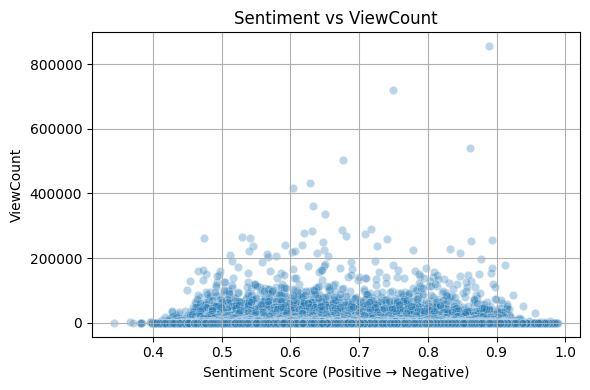

In [ ]:
from scipy.stats import spearmanr

# Correlation analysis between sentiment score and engagement metrics
for field in ['CommentCount', 'ViewCount']:
    # Compute Spearman rank correlation (non-parametric, for monotonic relationships)
    r, p = spearmanr(df['SentimentScore'], df[field])
    print(f"{field} vs SentimentScore: ρ = {r:.3f}, p = {p:.4f}")

    # Visualize the relationship with a scatter plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='SentimentScore', y=field, data=df, alpha=0.3)
    plt.title(f"Sentiment vs {field}")
    plt.xlabel("Sentiment Score (Positive → Negative)")
    plt.ylabel(field)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


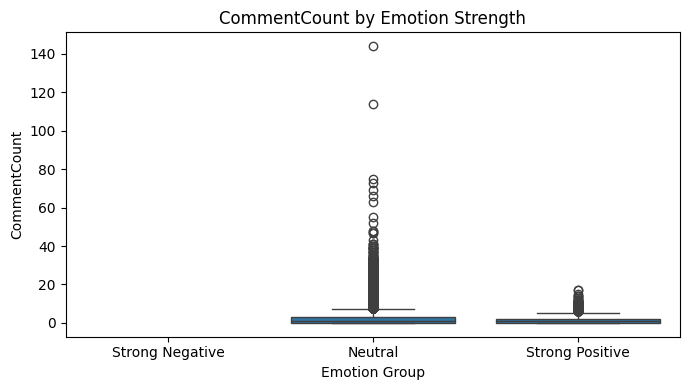

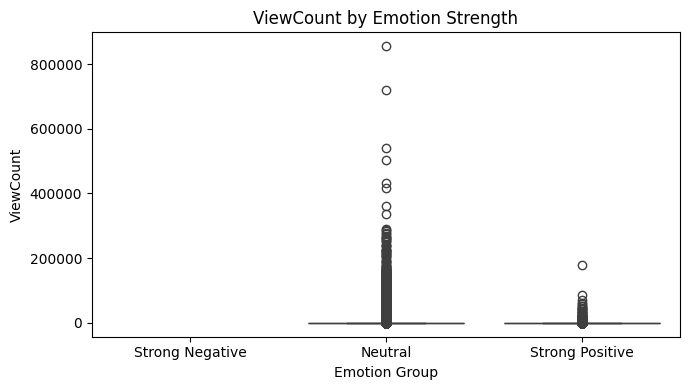

In [30]:
def label_emotion_strength(score):
    if score >= 0.9:
        return 'Strong Positive'
    elif score <= 0.1:
        return 'Strong Negative'
    else:
        return 'Neutral'

df['EmotionGroup'] = df['SentimentScore'].apply(label_emotion_strength)

for field in ['CommentCount', 'ViewCount']:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df, x='EmotionGroup', y=field, order=['Strong Negative', 'Neutral', 'Strong Positive'])
    plt.title(f"{field} by Emotion Strength")
    plt.xlabel("Emotion Group")
    plt.ylabel(field)
    plt.tight_layout()
    plt.show()


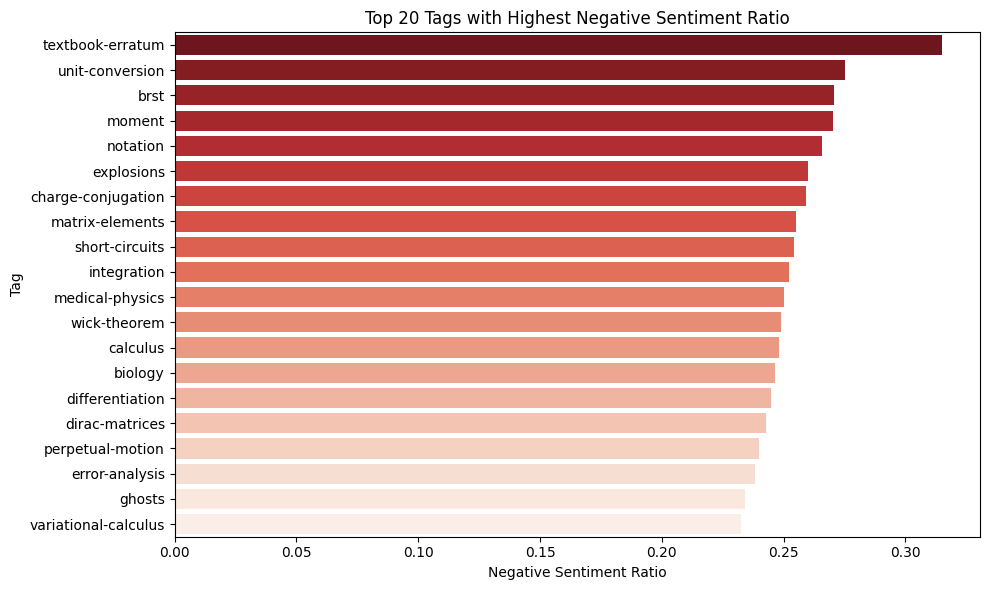

In [ ]:
# Keep rows that have both tags and sentiment labels
df_tags = df[df['Tags'].notnull() & df['SentimentLabel'].notnull()].copy()

# Extract list of tags from pipe-delimited string (remove surrounding pipes)
df_tags['TagList'] = df_tags['Tags'].str.strip('|').str.split('|')

# Explode the tag list so that each tag becomes a separate row
df_exploded = df_tags.explode('TagList')

# Filter out empty tag strings (e.g., from malformed input like "|a||b|")
df_exploded = df_exploded[df_exploded['TagList'] != '']

# Count number of posts per (Tag, SentimentLabel) pair
tag_sentiment_counts = df_exploded.groupby(['TagList', 'SentimentLabel']).size().reset_index(name='Count')

# Count total number of posts per tag (regardless of sentiment)
tag_totals = df_exploded.groupby('TagList').size().reset_index(name='Total')

# Merge and compute sentiment percentage
df_tag_summary = pd.merge(tag_sentiment_counts, tag_totals, on='TagList')
df_tag_summary['Percent'] = df_tag_summary['Count'] / df_tag_summary['Total']

# Filter out rare tags with too few total posts
MIN_POSTS = 100
df_tag_summary = df_tag_summary[df_tag_summary['Total'] >= MIN_POSTS]

# Focus on negative sentiment only
neg_tags = df_tag_summary[df_tag_summary['SentimentLabel'] == 'negative']

# Select top 20 tags with the highest negative sentiment ratio
top_neg = neg_tags.sort_values(by='Percent', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_neg, y='TagList', x='Percent', palette='Reds_r')
plt.title("Top 20 Tags with Highest Negative Sentiment Ratio")
plt.xlabel("Negative Sentiment Ratio")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()


In [37]:
df_tags


,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,CleanBodyNoMath,SentimentScore,SentimentLabel,Year,Month,Day,IsChristmas,Date,EmotionGroup,TagList
0,1,1,5.0,2010-11-02 18:59:01.140,87,20982.0,I often hear about subatomic particles having ...,7.0,520.0,2012-08-19 23:00:18.417,...,I often hear about subatomic particles having ...,0.6290,neutral,2010,11,2,False,2010-11-02,Neutral,"[quantum-mechanics, particle-physics, angular-..."
1,2,1,5704.0,2010-11-02 19:09:48.680,31,3946.0,How would you explain string theory to non-phy...,23.0,58382.0,2020-06-14 12:52:57.027,...,How would you explain string theory to non-phy...,0.7774,neutral,2010,11,2,False,2010-11-02,Neutral,"[string-theory, education]"
2,3,1,180.0,2010-11-02 19:11:05.857,46,3308.0,This is a question that has been posted at man...,40.0,2451.0,2013-01-28 22:30:52.200,...,This is a question that has been posted at man...,0.5788,neutral,2010,11,2,False,2010-11-02,Neutral,"[particle-physics, group-theory, representatio..."
5,7,1,46.0,2010-11-02 19:26:38.137,14,2583.0,What are the main problems that we need to sol...,23.0,2451.0,2012-11-04 17:28:11.530,...,What are the main problems that we need to sol...,0.7426,neutral,2010,11,2,False,2010-11-02,Neutral,"[quantum-mechanics, quantum-interpretations, h..."
7,9,1,0.0,2010-11-02 19:28:09.013,57,19706.0,Hamilton's principle states that a dynamic sys...,48.0,58382.0,2021-04-24 17:37:33.887,...,Hamilton's principle states that a dynamic sys...,0.8012,neutral,2010,11,2,False,2010-11-02,Neutral,"[lagrangian-formalism, variational-principle, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577294,808515,1,0.0,2024-03-31 22:06:18.577,-1,23.0,Hello i am now studying general plane motion f...,397871.0,2451.0,2024-04-01 01:30:20.040,...,Hello i am now studying general plane motion f...,0.7508,neutral,2024,3,31,False,2024-03-31,Neutral,"[newtonian-mechanics, rotational-dynamics, ref..."
577295,808516,1,0.0,2024-03-31 22:31:28.093,-4,39.0,For example I have the formula:\nMEI=MEF\nmgh+...,398503.0,2451.0,2024-04-01 01:24:41.323,...,For example I have the formula:\nMEI=MEF\nmgh+...,0.8890,neutral,2024,3,31,False,2024-03-31,Neutral,"[newtonian-mechanics, energy-conservation, vel..."
577297,808518,1,0.0,2024-03-31 22:49:37.613,1,32.0,Suppose we have a theory that is super-renorma...,288281.0,2451.0,2024-04-01 01:01:53.040,...,Suppose we have a theory that is super-renorma...,0.6876,neutral,2024,3,31,False,2024-03-31,Neutral,"[quantum-field-theory, renormalization, feynma..."
577298,808519,1,0.0,2024-03-31 22:59:29.267,0,32.0,What is the speed of light in a vacuum when th...,198517.0,2451.0,2024-04-01 00:57:51.470,...,What is the speed of light in a vacuum when th...,0.8629,neutral,2024,3,31,False,2024-03-31,Neutral,"[electromagnetic-radiation, visible-light, pho..."


In [ ]:
# Map sentiment labels to numeric values for aggregation
label_to_score = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}
df['SentimentNumeric'] = df['SentimentLabel'].map(label_to_score)

# Aggregate average sentiment and post count per user
user_sentiment = (
    df[df['OwnerUserId'].notnull()]
    .groupby('OwnerUserId')['SentimentNumeric']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'AvgSentiment', 'count': 'PostCount'})
)

# Define criteria for "negatively inclined" users:
# At least 5 posts and average sentiment ≤ –0.5
negative_users = user_sentiment[
    (user_sentiment['PostCount'] >= 5) &
    (user_sentiment['AvgSentiment'] <= -0.5)
]

# Display the top users with the most negative average sentiment
print(negative_users.sort_values(by='AvgSentiment').head())


       OwnerUserId  AvgSentiment  PostCount
41449     146473.0     -1.000000          5
41759     147609.0     -1.000000          5
2655        6195.0     -0.833333          6
11425      30712.0     -0.833333          6
75755     297316.0     -0.833333          6


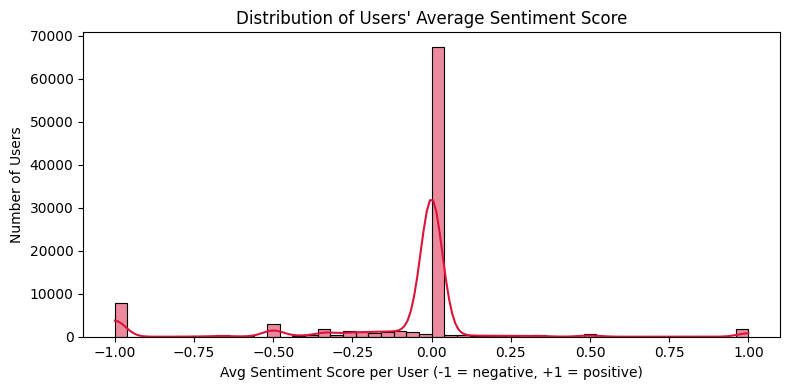

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(user_sentiment['AvgSentiment'], bins=50, kde=True, color='crimson')
plt.title("Distribution of Users' Average Sentiment Score")
plt.xlabel("Avg Sentiment Score per User (-1 = negative, +1 = positive)")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()
